# 03. Quality Filtering
## Synthetic Instruction Tuner - Week 2 Day 1-2

This notebook filters the raw instruction-response pairs for quality:
1. Load raw generated data
2. Apply rule-based quality filters
3. Analyze filtering statistics
4. Save high-quality filtered data

**Target**: Filter 1,500 raw samples → ~1,000 high-quality samples

**Expected runtime**:
- **T4 / A100**: 10-15 minutes (similar performance - CPU-bound task)

**Note**: Quality filtering is primarily CPU-intensive, so both T4 and A100 GPUs perform similarly for this step.

## 1. Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Project path
PROJECT_ROOT = "/content/drive/MyDrive/synthetic-instruction-tuner"

Mounted at /content/drive


In [2]:
# Load configuration
import json

with open(f"{PROJECT_ROOT}/config.json", 'r') as f:
    config = json.load(f)

print("Configuration loaded!")
print(f"Target filtered samples: {config['data_generation']['target_filtered_samples']}")

Configuration loaded!
Target filtered samples: 1000


In [3]:
import json
import os
import re
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
import random
import numpy as np

random.seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Load Raw Data

In [4]:
# Load raw instruction data
RAW_DATA_PATH = f"{config['paths']['data_raw']}/instructions_raw.json"

with open(RAW_DATA_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

print(f"Loaded {len(raw_data)} raw samples")

Loaded 1500 raw samples


In [5]:
# Preview some samples
print("Sample data:")
print("=" * 50)
for i, sample in enumerate(random.sample(raw_data, min(3, len(raw_data)))):
    print(f"\n--- Sample {i+1} ---")
    print(f"Instruction: {sample['instruction'][:150]}...")
    print(f"Response: {sample['response'][:150]}...")

Sample data:

--- Sample 1 ---
Instruction: ## Step 1: Understand the given equation
We are given the equation $2 \sin^2 x + 4 \cos^2 x + 3 \sin x = 4 \cos^2 x + 3$.

## Step 2: Apply the Pythag...
Response: ## Step 5: Simplify the equation further
Expanding the equation further, we get $2 \sin^2 x + 4 - 4 \sin^2 x + 3 \sin x = 4 - 4 \sin^2 x + 3$.

## Ste...

--- Sample 2 ---
Instruction: ## Step 1: Understand the problem and the given information.
The problem is asking us to find the value of x in the equation 5x + 3y = 11, where we ar...
Response: ## Step 1: Understand the problem and the given information.
We are given a linear equation 5x + 3y = 11 and a slope of 2. We need to find the value o...

--- Sample 3 ---
Instruction: Let $\{a_n\}$ and $\{b_n\}$ be two sequences defined by the recurrence relations:
$a_1 = 2$, $a_{n+1} = a_n^2 - 2$ for all $n \ge 1$, and $b_1 = 1$, $...
Response: ## Step 1: We need to find the 101st term of the sequence $\{a_n\}$ and the 101st term of the 

## 3. Quality Filter Class

In [27]:
@dataclass
class FilterResult:
    """Result of filtering a single sample."""
    passed: bool
    score: float
    reasons: List[str]


class QualityFilter:
    """Rule-based quality filter for instruction-response pairs."""

    def __init__(self, config: Optional[Dict] = None):
        self.config = config or {}

        # Length thresholds
        self.min_instruction_words = self.config.get('min_instruction_words', 3)
        self.max_instruction_words = self.config.get('max_instruction_words', 500)
        self.min_response_words = self.config.get('min_response_words', 10)
        self.max_response_words = self.config.get('max_response_words', 2000)

        # Quality thresholds
        self.min_quality_score = self.config.get('min_quality_score', 0.5)
        self.max_repetition_ratio = self.config.get('max_repetition_ratio', 0.3)

        # Toxic keywords (basic list)
        self.toxic_keywords = self._load_toxic_keywords()

        # Low quality patterns
        self.low_quality_patterns = [
            r'^(hi|hello|hey|ok|okay|sure|yes|no|thanks|thank you)[\s\.\!]*$',
            r'^I (don\'t|cannot|can\'t) (help|assist|answer)',
            r'as an AI',
            r'I\'m sorry, but I',
            r'I apologize, but',
            r'^\s*$',
            r'^[^\w\s]+$',
        ]

    def _load_toxic_keywords(self) -> List[str]:
        return [
            'kill', 'murder', 'suicide', 'terrorist', 'bomb', 'weapon',
            'hack into', 'steal password', 'illegal drug', 'child abuse',
        ]

    def filter_sample(self, sample: Dict) -> FilterResult:
        instruction = sample.get('instruction', '')
        response = sample.get('response', '')

        reasons = []
        scores = []

        # Apply all filters
        filters = [
            (self._check_length, 0.15),
            (self._check_language, 0.10),
            (self._check_repetition, 0.20),
            (self._check_format, 0.15),
            (self._check_toxicity, 0.15),
            (self._check_content_quality, 0.25),
        ]

        weighted_score = 0
        for filter_func, weight in filters:
            if filter_func == self._check_repetition:
                passed, score, reason = filter_func(response)
            else:
                passed, score, reason = filter_func(instruction, response)

            if not passed:
                reasons.append(reason)
            weighted_score += score * weight

        passed = len(reasons) == 0 and weighted_score >= self.min_quality_score
        return FilterResult(passed=passed, score=weighted_score, reasons=reasons)

    def _check_length(self, instruction: str, response: str) -> Tuple[bool, float, str]:
        inst_words = len(instruction.split())
        resp_words = len(response.split())

        if inst_words < self.min_instruction_words:
            return False, 0.0, f"Instruction too short ({inst_words} words)"
        if inst_words > self.max_instruction_words:
            return False, 0.0, f"Instruction too long ({inst_words} words)"
        if resp_words < self.min_response_words:
            return False, 0.0, f"Response too short ({resp_words} words)"
        if resp_words > self.max_response_words:
            return False, 0.5, f"Response too long ({resp_words} words)"

        ideal_length = 200
        length_diff = abs(resp_words - ideal_length)
        score = max(0.5, 1.0 - (length_diff / 500))
        return True, score, ""

    def _check_language(self, instruction: str, response: str) -> Tuple[bool, float, str]:
        combined = instruction + " " + response
        english_indicators = ['the', 'is', 'are', 'was', 'were', 'have', 'has',
                            'will', 'would', 'could', 'should', 'can', 'may',
                            'a', 'an', 'and', 'or', 'but', 'if', 'then']

        words = combined.lower().split()
        if len(words) == 0:
            return False, 0.0, "Empty content"

        english_word_count = sum(1 for w in words if w in english_indicators)
        english_ratio = english_word_count / len(words)

        ascii_chars = sum(1 for c in combined if ord(c) < 128)
        ascii_ratio = ascii_chars / max(len(combined), 1)

        score = (english_ratio * 0.5 + ascii_ratio * 0.5)

        if ascii_ratio < 0.8:
            return False, score, "Non-English content detected"
        return True, min(1.0, score + 0.5), ""

    def _check_repetition(self, response: str) -> Tuple[bool, float, str]:
        words = response.lower().split()
        if len(words) < 10:
            return True, 1.0, ""

        word_counts = {}
        for word in words:
            word_counts[word] = word_counts.get(word, 0) + 1

        common_words = {'the', 'a', 'an', 'is', 'are', 'was', 'were', 'to', 'of', 'and', 'in', 'for', 'on', 'with'}
        significant_words = {w: c for w, c in word_counts.items() if w not in common_words and len(w) > 2}

        if significant_words:
            max_repeat = max(significant_words.values())
            repetition_ratio = max_repeat / len(words)
            if repetition_ratio > self.max_repetition_ratio:
                return False, 0.3, f"High word repetition ({repetition_ratio:.2%})"

        for n in [3, 4, 5]:
            if len(words) >= n * 3:
                ngrams = [' '.join(words[i:i+n]) for i in range(len(words) - n + 1)]
                ngram_counts = {}
                for ng in ngrams:
                    ngram_counts[ng] = ngram_counts.get(ng, 0) + 1
                max_ngram_repeat = max(ngram_counts.values())
                if max_ngram_repeat > 8:
                    return False, 0.2, "Repeated phrases detected"

        return True, 1.0, ""

    def _check_format(self, instruction: str, response: str) -> Tuple[bool, float, str]:
        for pattern in self.low_quality_patterns:
            if re.search(pattern, instruction, re.IGNORECASE):
                return False, 0.0, "Low quality instruction pattern"

        for pattern in self.low_quality_patterns:
            if re.search(pattern, response, re.IGNORECASE):
                return False, 0.1, "Low quality response pattern"

        refusal_patterns = [
            r"I (can't|cannot|won't|will not) (help|assist|provide)",
            r"I'm (not able|unable) to",
            r"I don't have (access|the ability)",
        ]
        for pattern in refusal_patterns:
            if re.search(pattern, response, re.IGNORECASE):
                return False, 0.0, "Response is a refusal"

        response_stripped = response.strip()
        if response_stripped and response_stripped[-1] not in '.!?"\')':
            return True, 0.7, ""
        return True, 1.0, ""

    def _check_toxicity(self, instruction: str, response: str) -> Tuple[bool, float, str]:
        combined = (instruction + " " + response).lower()
        for keyword in self.toxic_keywords:
            if keyword.lower() in combined:
                educational_context = ['history', 'prevention', 'awareness', 'education', 'study']
                if any(ctx in combined for ctx in educational_context):
                    continue
                return False, 0.0, "Potentially harmful content detected"
        return True, 1.0, ""

    def _check_content_quality(self, instruction: str, response: str) -> Tuple[bool, float, str]:
        score = 1.0
        if '?' in instruction:
            score += 0.1
        if any(word in instruction.lower() for word in ['explain', 'describe', 'how', 'what', 'why', 'write', 'create']):
            score += 0.1

        response_words = response.split()
        unique_words = len(set(response_words))
        if len(response_words) > 0:
            diversity = unique_words / len(response_words)
            score *= (0.5 + diversity * 0.5)

        if '\n\n' in response or re.search(r'^\d+\.|\-|\*', response, re.MULTILINE):
            score += 0.1

        score = min(1.0, max(0.0, score))
        if score < 0.4:
            return False, score, "Low content quality"
        return True, score, ""

    def filter_batch(self, samples: List[Dict], verbose: bool = False) -> Tuple[List[Dict], Dict]:
        filtered = []
        stats = {
            'total': len(samples),
            'passed': 0,
            'failed': 0,
            'reasons': {},
            'score_distribution': []
        }

        for i, sample in enumerate(samples):
            result = self.filter_sample(sample)
            stats['score_distribution'].append(result.score)

            if result.passed:
                filtered.append({**sample, 'quality_score': result.score})
                stats['passed'] += 1
            else:
                stats['failed'] += 1
                for reason in result.reasons:
                    key = reason.split('(')[0].strip()
                    stats['reasons'][key] = stats['reasons'].get(key, 0) + 1

            if verbose and (i + 1) % 1000 == 0:
                print(f"Processed {i + 1}/{len(samples)} samples")

        return filtered, stats

print("QualityFilter class defined!")

QualityFilter class defined!


## 4. Test Filter on Sample Data

In [28]:
# Initialize filter with config
filter_config = config.get('quality_filter', {})
quality_filter = QualityFilter(filter_config)

print("Filter initialized with settings:")
print(f"  Min instruction words: {quality_filter.min_instruction_words}")
print(f"  Max instruction words: {quality_filter.max_instruction_words}")
print(f"  Min response words: {quality_filter.min_response_words}")
print(f"  Max response words: {quality_filter.max_response_words}")
print(f"  Min quality score: {quality_filter.min_quality_score}")

Filter initialized with settings:
  Min instruction words: 3
  Max instruction words: 500
  Min response words: 10
  Max response words: 2000
  Min quality score: 0.5


In [29]:
# Test on individual samples
print("Testing filter on individual samples:")
print("=" * 50)

for i, sample in enumerate(raw_data[:5]):
    result = quality_filter.filter_sample(sample)
    status = "PASS" if result.passed else "FAIL"
    print(f"\n[{i+1}] {status} (score: {result.score:.3f})")
    print(f"    Instruction: {sample['instruction'][:80]}...")
    if result.reasons:
        print(f"    Reasons: {', '.join(result.reasons)}")

Testing filter on individual samples:

[1] PASS (score: 0.895)
    Instruction: ## Step 1: Define the problem
We need to find the value of x such that when 1 is...

[2] PASS (score: 0.894)
    Instruction: ## Step 1: Understand the Problem
The problem asks us to find the number of inte...

[3] PASS (score: 0.887)
    Instruction: ## Step 1: Understand the problem
The problem asks us to find the greatest commo...

[4] PASS (score: 0.940)
    Instruction: The number 3 is a prime factor of the expression 2^x * 3^y * 4^z. If x, y, and z...

[5] PASS (score: 0.883)
    Instruction: Let $f(x)$ be a function such that
\[f(x+y) = xy + f(x) + f(y)\] 
and $f(0) = 0,...


## 5. Apply Filter to All Data

In [30]:
from tqdm import tqdm

print(f"Filtering {len(raw_data)} samples...")
print("=" * 50)

filtered_data, stats = quality_filter.filter_batch(raw_data, verbose=True)

print(f"\nFiltering complete!")
print(f"Passed: {stats['passed']} / {stats['total']} ({stats['passed']/stats['total']*100:.1f}%)")

Filtering 1500 samples...
Processed 1000/1500 samples

Filtering complete!
Passed: 1258 / 1500 (83.9%)


## 6. Analyze Filtering Results

In [31]:
import numpy as np

print("=" * 50)
print("FILTERING STATISTICS")
print("=" * 50)
print(f"\nTotal samples: {stats['total']}")
print(f"Passed: {stats['passed']} ({stats['passed']/stats['total']*100:.1f}%)")
print(f"Failed: {stats['failed']} ({stats['failed']/stats['total']*100:.1f}%)")

print(f"\nQuality Score Distribution:")
scores = stats['score_distribution']
print(f"  Mean: {np.mean(scores):.3f}")
print(f"  Std: {np.std(scores):.3f}")
print(f"  Min: {np.min(scores):.3f}")
print(f"  Max: {np.max(scores):.3f}")
print(f"  Median: {np.median(scores):.3f}")

FILTERING STATISTICS

Total samples: 1500
Passed: 1258 (83.9%)
Failed: 242 (16.1%)

Quality Score Distribution:
  Mean: 0.882
  Std: 0.065
  Min: 0.656
  Max: 0.990
  Median: 0.901


In [32]:
# Failure reasons breakdown
print("\nFailure Reasons Breakdown:")
print("-" * 40)
for reason, count in sorted(stats['reasons'].items(), key=lambda x: -x[1]):
    pct = count / stats['failed'] * 100 if stats['failed'] > 0 else 0
    print(f"  {reason}: {count} ({pct:.1f}%)")


Failure Reasons Breakdown:
----------------------------------------
  Repeated phrases detected: 156 (64.5%)
  Response too short: 76 (31.4%)
  Potentially harmful content detected: 5 (2.1%)
  Response is a refusal: 5 (2.1%)


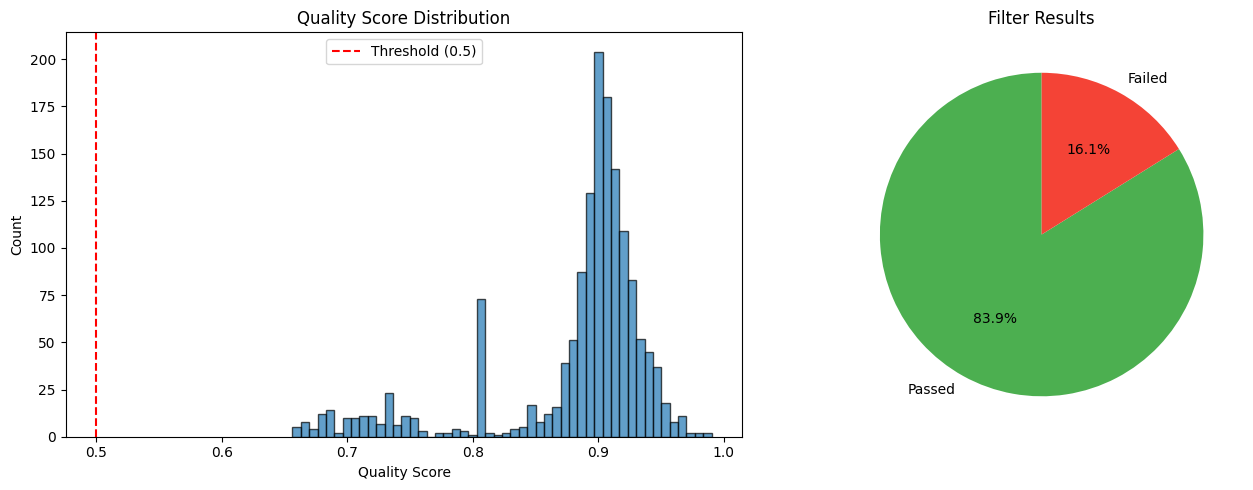


Figure saved to /content/drive/MyDrive/synthetic-instruction-tuner/evaluation/figures/filtering_stats.png


In [33]:
# Visualize score distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Score histogram
axes[0].hist(scores, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=quality_filter.min_quality_score, color='r', linestyle='--', label=f'Threshold ({quality_filter.min_quality_score})')
axes[0].set_xlabel('Quality Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Quality Score Distribution')
axes[0].legend()

# Pass/Fail pie chart
labels = ['Passed', 'Failed']
sizes = [stats['passed'], stats['failed']]
colors = ['#4CAF50', '#F44336']
axes[1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Filter Results')

plt.tight_layout()
plt.savefig(f"{config['paths']['evaluation_figures']}/filtering_stats.png", dpi=150)
plt.show()

print(f"\nFigure saved to {config['paths']['evaluation_figures']}/filtering_stats.png")

## 7. Adjust Filter if Needed

In [34]:
# Check if we have enough samples
TARGET_FILTERED = config['data_generation']['target_filtered_samples']

print(f"Target filtered samples: {TARGET_FILTERED}")
print(f"Current filtered samples: {len(filtered_data)}")

if len(filtered_data) >= TARGET_FILTERED:
    print(f"\n✓ Sufficient samples! We have {len(filtered_data) - TARGET_FILTERED} extra.")

    # If too many, select top quality
    if len(filtered_data) > TARGET_FILTERED * 1.2:  # More than 20% extra
        print(f"Selecting top {TARGET_FILTERED} by quality score...")
        filtered_data = sorted(filtered_data, key=lambda x: x['quality_score'], reverse=True)[:TARGET_FILTERED]
        print(f"Selected {len(filtered_data)} samples")
else:
    deficit = TARGET_FILTERED - len(filtered_data)
    print(f"\n⚠ Need {deficit} more samples.")
    print("Options:")
    print("  1. Generate more raw data (run 02_magpie_generation.ipynb again)")
    print("  2. Relax filter thresholds (reduce min_quality_score)")
    print("  3. Proceed with fewer samples")

Target filtered samples: 1000
Current filtered samples: 1258

✓ Sufficient samples! We have 258 extra.
Selecting top 1000 by quality score...
Selected 1000 samples


In [37]:
# Optional: Relax filters to get more samples

if len(filtered_data) < TARGET_FILTERED:
    print("Relaxing filter thresholds...")
    print("Reason: Magpie data has structured responses (math/code) with repeated phrases")

    relaxed_config = config.get('quality_filter', {}).copy()
    relaxed_config.update({
        'min_quality_score': 0.4,      # 0.5 → 0.4
        'max_repetition_ratio': 0.5,   # 0.3 → 0.5
        'min_response_words': 8,       # 10 → 8
    })

    relaxed_filter = QualityFilter(relaxed_config)
    filtered_data, stats = relaxed_filter.filter_batch(raw_data, verbose=True)

    print(f"\n✅ After relaxing: {len(filtered_data)} samples")
    print(f"Pass rate: {stats['passed']/stats['total']*100:.1f}%")

    print("\n⚠️ Please re-run cells from Cell 16 onwards to update statistics")

## 8. Analyze Filtered Data Quality

In [38]:
# Statistics on filtered data
instruction_lengths = [len(d['instruction'].split()) for d in filtered_data]
response_lengths = [len(d['response'].split()) for d in filtered_data]
quality_scores = [d['quality_score'] for d in filtered_data]

print("=" * 50)
print("FILTERED DATA STATISTICS")
print("=" * 50)
print(f"\nTotal filtered samples: {len(filtered_data)}")

print(f"\nInstruction length (words):")
print(f"  Mean: {np.mean(instruction_lengths):.1f}")
print(f"  Median: {np.median(instruction_lengths):.1f}")
print(f"  Range: {np.min(instruction_lengths)} - {np.max(instruction_lengths)}")

print(f"\nResponse length (words):")
print(f"  Mean: {np.mean(response_lengths):.1f}")
print(f"  Median: {np.median(response_lengths):.1f}")
print(f"  Range: {np.min(response_lengths)} - {np.max(response_lengths)}")

print(f"\nQuality scores:")
print(f"  Mean: {np.mean(quality_scores):.3f}")
print(f"  Median: {np.median(quality_scores):.3f}")
print(f"  Range: {np.min(quality_scores):.3f} - {np.max(quality_scores):.3f}")

FILTERED DATA STATISTICS

Total filtered samples: 1000

Instruction length (words):
  Mean: 156.0
  Median: 166.0
  Range: 13 - 224

Response length (words):
  Mean: 145.6
  Median: 142.0
  Range: 10 - 383

Quality scores:
  Mean: 0.915
  Median: 0.911
  Range: 0.891 - 0.990


In [39]:
# Show sample filtered data
print("\n" + "=" * 50)
print("SAMPLE FILTERED DATA")
print("=" * 50)

# Show top quality samples
top_samples = sorted(filtered_data, key=lambda x: x['quality_score'], reverse=True)[:3]
print("\nTop quality samples:")
for i, sample in enumerate(top_samples):
    print(f"\n--- Top {i+1} (score: {sample['quality_score']:.3f}) ---")
    print(f"Instruction: {sample['instruction'][:150]}...")
    print(f"Response: {sample['response'][:150]}...")


SAMPLE FILTERED DATA

Top quality samples:

--- Top 1 (score: 0.990) ---
Instruction: What do you think it means to "be" in the context of "I am a writer."?
"Be" is typically used to describe a state of being or an action one performs. ...
Response: Your interpretation is spot on. In the sentence "I am a writer," the verb "be" is functioning as a linking verb, also known as a copula. Its primary r...

--- Top 2 (score: 0.990) ---
Instruction: What do you think it means to "be" in the context of "I am a writer."?
"Be" is typically used to describe a state of being or an action one performs. ...
Response: Your interpretation is spot on. In the sentence "I am a writer," the verb "be" is functioning as a linking verb, also known as a copula. Its primary r...

--- Top 3 (score: 0.977) ---
Instruction: What are some other interesting foods you can make with eggplant?
In addition to eggplant parmesan, there asparagus is another ingredient that can com...
Response: Here are some other interes

## 9. Save Filtered Data

In [40]:
# Save filtered data
FILTERED_PATH = f"{config['paths']['data_filtered']}/instructions_filtered.json"

with open(FILTERED_PATH, 'w', encoding='utf-8') as f:
    json.dump(filtered_data, f, ensure_ascii=False, indent=2)

print(f"Filtered data saved to: {FILTERED_PATH}")
print(f"Total samples: {len(filtered_data)}")

Filtered data saved to: /content/drive/MyDrive/synthetic-instruction-tuner/data/filtered/instructions_filtered.json
Total samples: 1000


In [41]:
# Save filtering statistics
STATS_PATH = f"{config['paths']['evaluation_results']}/filtering_stats.json"

# Convert numpy types for JSON serialization
stats_json = {
    'total': stats['total'],
    'passed': stats['passed'],
    'failed': stats['failed'],
    'pass_rate': stats['passed'] / stats['total'],
    'reasons': stats['reasons'],
    'score_stats': {
        'mean': float(np.mean(scores)),
        'std': float(np.std(scores)),
        'min': float(np.min(scores)),
        'max': float(np.max(scores)),
        'median': float(np.median(scores)),
    }
}

with open(STATS_PATH, 'w') as f:
    json.dump(stats_json, f, indent=2)

print(f"Statistics saved to: {STATS_PATH}")

Statistics saved to: /content/drive/MyDrive/synthetic-instruction-tuner/evaluation/results/filtering_stats.json


## 10. Prepare for SFT Training Format

In [42]:
# Convert to SFT training format (instruction-response pairs)
sft_data = []
for sample in filtered_data:
    sft_data.append({
        "instruction": sample['instruction'],
        "input": "",  # No additional input
        "output": sample['response']
    })

# Save SFT format
SFT_DATA_PATH = f"{config['paths']['data_filtered']}/sft_data.json"
with open(SFT_DATA_PATH, 'w', encoding='utf-8') as f:
    json.dump(sft_data, f, ensure_ascii=False, indent=2)

print(f"SFT training data saved to: {SFT_DATA_PATH}")
print(f"Total samples: {len(sft_data)}")

SFT training data saved to: /content/drive/MyDrive/synthetic-instruction-tuner/data/filtered/sft_data.json
Total samples: 1000


In [43]:
# Split into train/validation sets
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(sft_data, test_size=0.1, random_state=42)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Save splits
with open(f"{config['paths']['data_filtered']}/sft_train.json", 'w', encoding='utf-8') as f:
    json.dump(train_data, f, ensure_ascii=False, indent=2)

with open(f"{config['paths']['data_filtered']}/sft_val.json", 'w', encoding='utf-8') as f:
    json.dump(val_data, f, ensure_ascii=False, indent=2)

print(f"\nTrain/val splits saved!")

Training samples: 900
Validation samples: 100

Train/val splits saved!


## ✅ Filtering Complete!

### Summary:
- Filtered data saved to `data/filtered/instructions_filtered.json`
- SFT training data saved to `data/filtered/sft_data.json`
- Train/val splits saved for training

### Performance Note:
- Quality filtering is CPU-bound (not GPU-intensive)
- **T4 and A100 perform similarly** for this step (~10-15 minutes)
- The GPU benefits appear in training steps (05, 06)

### Next Steps:
1. Proceed to `04_preference_generation.ipynb` for DPO preference data
2. Target: Generate 600 preference pairs from filtered 1K samples
3. **A100 users**: Expect 2-3 hours (vs 4-6h on T4) for preference generation